In [1]:
import os
import csv
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure


## Helper functions to load and process original csv files

In [2]:
# this function load one .cvs (a sequence)
def load_data(dataset, csv_folder="./csv-files/"):
    if dataset == "ambient_temp":
        data_file = os.path.join(csv_folder, "ambient_temperature_system_failure.csv")
        anomalies = ["2013-12-22 20:00:00", "2014-04-13 09:00:00"]
        t_unit = "hour"
    elif dataset == "cpu_utilization":
        data_file = os.path.join(csv_folder, "cpu_utilization_asg_misconfiguration.csv")
        anomalies = ["2014-07-12 02:04:00", "2014-07-14 21:44:00"]
        t_unit = "5 min"
    elif dataset == "ec2_request":
        data_file = os.path.join(csv_folder, "ec2_request_latency_system_failure.csv")
        anomalies = [
            "2014-03-14 09:06:00",
            "2014-03-18 22:41:00",
            "2014-03-21 03:01:00",
        ]
        t_unit = "5 min"
    elif dataset == "machine_temp":
        data_file = os.path.join(csv_folder, "machine_temperature_system_failure.csv")
        anomalies = [
            "2013-12-11 06:00:00",
            "2013-12-16 17:25:00",
            "2014-01-28 13:55:00",
            "2014-02-08 14:30:00",
        ]
        t_unit = "5 min"
    elif dataset == "rogue_agent_key_hold":
        data_file = os.path.join(csv_folder, "rogue_agent_key_hold.csv")
        anomalies = ["2014-07-15 08:30:00", "2014-07-17 09:50:00"]
        t_unit = "5 min"
    elif dataset == "rogue_agent_key_updown":
        data_file = os.path.join(csv_folder, "rogue_agent_key_updown.csv")
        anomalies = ["2014-07-15 04:00:00", "2014-07-17 08:50:00"]
        t_unit = "5 min"
    elif dataset == "nyc_taxi":
        data_file = os.path.join(csv_folder, "nyc_taxi.csv")
        anomalies = [
            "2014-11-01 19:00:00",
            "2014-11-27 15:30:00",
            "2014-12-25 15:00:00",
            "2015-01-01 01:00:00",
            "2015-01-27 00:00:00",
        ]
        t_unit = "30 min"

    t = []
    readings = []
    idx_anomaly = []
    i = 0
    with open(data_file) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=",")
        print("\n--> Anomalies occur at:")
        for row in readCSV:
            if i > 0:
                t.append(i)
                readings.append(float(row[1]))
                for j in range(len(anomalies)):
                    if row[0] == anomalies[j]:
                        idx_anomaly.append(i)
                        print("  timestamp #{}: {}".format(j, row[0]))
            i = i + 1
    t = np.asarray(t)
    readings = np.asarray(readings)
    print("\nOriginal csv file contains {} timestamps.".format(t.shape))
    print("Processed time series contain {} readings.".format(readings.shape))
    print("Anomaly indices are {}".format(idx_anomaly))

    return t, t_unit, readings, idx_anomaly


In [3]:
# This function plots a dataset with the train/test split and known anomalies
# Relies on helper function load_data()


def process_and_save_specified_dataset(dataset, idx_split, y_scale=5, save_file=False):
    t, t_unit, readings, idx_anomaly = load_data(dataset)

    # split into training and test sets
    training = readings[idx_split[0] : idx_split[1]]
    t_train = t[idx_split[0] : idx_split[1]]

    # normalise by training mean and std
    train_m = np.mean(training)
    train_std = np.std(training)
    print("\nTraining set mean is {}".format(train_m))
    print("Training set std is {}".format(train_std))
    readings_normalised = (readings - train_m) / train_std

    training = readings_normalised[idx_split[0] : idx_split[1]]
    if idx_split[0] == 0:
        test = readings_normalised[idx_split[1] :]
        t_test = t[idx_split[1] :] - idx_split[1]
        idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]
    else:
        test = [
            readings_normalised[: idx_split[0]],
            readings_normalised[idx_split[1] :],
        ]
        t_test = [t[: idx_split[0]], t[idx_split[1] :] - idx_split[1]]
        idx_anomaly_split = np.squeeze(
            np.argwhere(np.asarray(idx_anomaly) > idx_split[0])
        )
        idx_anomaly_test = [
            np.asarray(idx_anomaly[: idx_anomaly_split[0]]),
            np.asarray(idx_anomaly[idx_anomaly_split[0] :]) - idx_split[1],
        ]
    print("Anomaly indices in the test set are {}".format(idx_anomaly_test))

    if save_file:
        save_dir = "."
        np.savez(
            save_dir + dataset + ".npz",
            t=t,
            t_unit=t_unit,
            readings=readings,
            idx_anomaly=idx_anomaly,
            idx_split=idx_split,
            training=training,
            test=test,
            train_m=train_m,
            train_std=train_std,
            t_train=t_train,
            t_test=t_test,
            idx_anomaly_test=idx_anomaly_test,
        )
        print(
            "\nProcessed time series are saved at {}".format(
                save_dir + dataset + ".npz"
            )
        )
    else:
        print("\nProcessed time series are not saved.")

    # plot the whole normalised sequence
    fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor="k")
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    # axs = axs.ravel()
    # for i in range(4):
    axs.plot(t, readings_normalised)
    if idx_split[0] == 0:
        axs.plot(idx_split[1] * np.ones(20), np.linspace(-y_scale, y_scale, 20), "b--")
    else:
        for i in range(2):
            axs.plot(
                idx_split[i] * np.ones(20), np.linspace(-y_scale, y_scale, 20), "b--"
            )
    for j in range(len(idx_anomaly)):
        axs.plot(
            idx_anomaly[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), "r--"
        )
    #     axs.plot(data[:,1])
    axs.grid(True)
    axs.set_xlim(0, len(t))
    axs.set_ylim(-y_scale, y_scale)
    axs.set_xlabel("timestamp (every {})".format(t_unit))
    axs.set_ylabel("normalised readings")
    axs.set_title(
        "{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(
            dataset, train_m, train_std
        )
    )
    axs.legend(("data", "train test set split", "anomalies"))

    return t, readings_normalised


## Example on ambient temperature series


--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]

Processed time series are not saved.


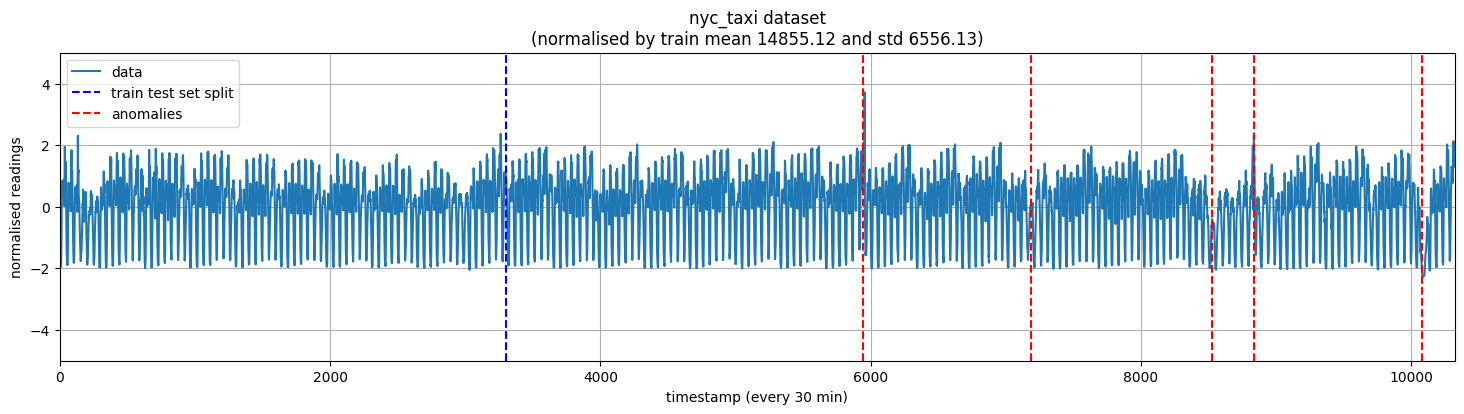

In [7]:
dataset = "nyc_taxi"
idx_split = [0, 3300]

t, readings_normalised = process_and_save_specified_dataset(dataset, idx_split)